<a href="https://colab.research.google.com/github/aditya9710/DeepExploration/blob/main/PointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Point Cloud Classification with PointNet**

In [19]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [20]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


In [21]:
data_dir = tf.keras.utils.get_file(
    "modelnet.zip",
    "https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(data_dir), "ModelNet10")

# **Visualize Dataset**

In [22]:
mesh = trimesh.load(os.path.join(data_dir, "chair/train/chair_0001.off"))
mesh.show()

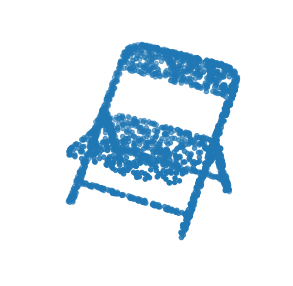

In [23]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:,0], points[:,1], points[:,2])
ax.set_axis_off()
plt.show()

# **Function to parse data**

In [24]:
def parse_dataset(num_points=2048):
  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map = {}
  folders = glob.glob(os.path.join(data_dir, "[!README]*"))

  for i, folder in enumerate(folders):
    print("Processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  return (
    np.array(train_points),
    np.array(test_points),
    np.array(train_labels),
    np.array(test_labels),
    class_map,
  )

In [25]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

Processing class: toilet
Processing class: bathtub
Processing class: table
Processing class: monitor
Processing class: sofa
Processing class: dresser
Processing class: desk
Processing class: night_stand
Processing class: chair
Processing class: bed


# **Augmentation of Train Dataset**

In [34]:
def augment(points, label):
  points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
  points = tf.random.shuffle(points)
  return points, label

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# **Build Model**

In [36]:
  def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)
  
  def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [37]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
  def __init__(self, num_features, l2reg=0.001):
    self.num_features = num_features
    self.l2reg = l2reg
    self.eye = tf.eye(num_features)

  def __call__(self, x):
    x = tf.reshape(x, (-1, self.num_features, self.num_features))
    xxt = tf.tensordot(x, x, axes=(2,2))
    xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
    return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

# **Function to create T-Net Layers**

In [38]:
def tnet(inputs, num_features):
    # Initialize bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features*num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2,1))([inputs, feat_T])


# **Creat the Convolution Neural Network**

In [39]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 2048, 32)     128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 2048, 32)    128         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 2048, 32)     0           ['batch_normalization_34[0

# **Compile & Train the Model**

In [40]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"]
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 52s 353ms/step - loss: 3.5125 - sparse_categorical_accuracy: 0.2791 - val_loss: 390694048890880.0000 - val_sparse_categorical_accuracy: 0.2159
Epoch 2/20
125/125 [==============================] - 44s 348ms/step - loss: 3.0984 - sparse_categorical_accuracy: 0.3525 - val_loss: 782.0956 - val_sparse_categorical_accuracy: 0.2037
Epoch 3/20
125/125 [==============================] - 44s 348ms/step - loss: 2.8086 - sparse_categorical_accuracy: 0.4435 - val_loss: 42172.9297 - val_sparse_categorical_accuracy: 0.3073
Epoch 4/20
125/125 [==============================] - 44s 348ms/step - loss: 2.6527 - sparse_categorical_accuracy: 0.5244 - val_loss: 534506373120.0000 - val_sparse_categorical_accuracy: 0.4328
Epoch 5/20
125/125 [==============================] - 44s 349ms/step - loss: 2.4305 - sparse_categorical_accuracy: 0.5755 - val_loss: 2.8511 - val_sparse_categorical_accuracy: 0.4108
Epoch 6/20
125/125 [==============================] - 

# **Visualize the Predictions**

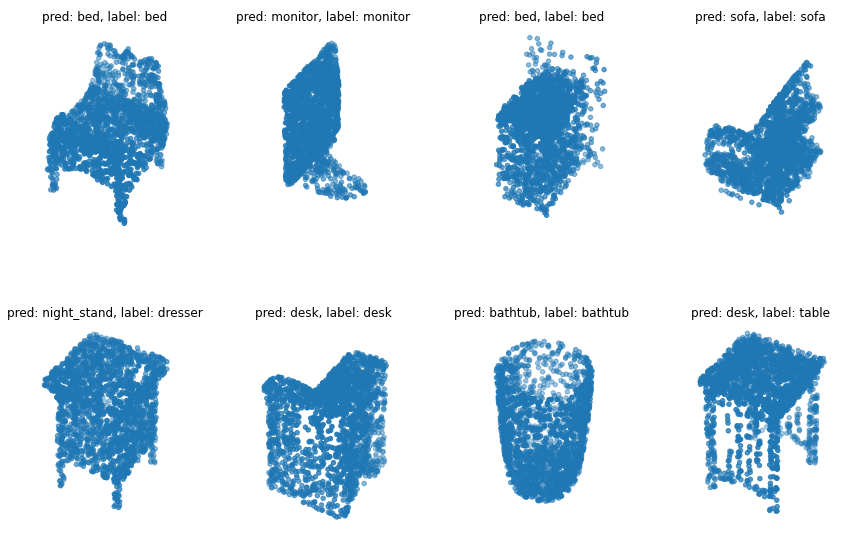

In [41]:
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# Run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)
points = points.numpy()

# Plot points with predicted class and label
fig = plt.figure(figsize=(15,10))
for i in range(8):
  ax = fig.add_subplot(2, 4, i+1, projection="3d")
  ax.scatter(points[i,:,0], points[i,:,1], points[i,:,2])
  ax.set_title(
      "pred: {:}, label: {:}".format(
          CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
      )
  )
  ax.set_axis_off()
plt.show()